In [1]:
from ovarian_can.infrastructure.path_facade.preprocess_path_resolver import PreprocessPathResolver
from ovarian_can.preprocess.abstract_path_resolver import AbstractPreprocessPathResolver
import joblib
# DI: 抽象インターフェースを経由してパス取得
resolver: AbstractPreprocessPathResolver = PreprocessPathResolver()
# input/outputパス取得
input_joblib_path = resolver.get_input_joblib_path()
intermediate_joblib_path = resolver.get_intermediate_joblib_path()
output_joblib_path = resolver.get_output_joblib_path()
print("Input path:", input_joblib_path)
print("Output path:", output_joblib_path)

Input path: /Users/masaki/ovarian_can/data/interim/xenium_ovarian_cancer_preprocessed.joblib
Output path: /Users/masaki/ovarian_can/data/processed/xenium_ovarian_cancer_after_preprocessing.joblib


In [2]:
# 前処理前のデータを読み込み
adata = joblib.load(input_joblib_path)
adata

AnnData object with n_obs × n_vars = 247636 × 480
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

<Axes: >

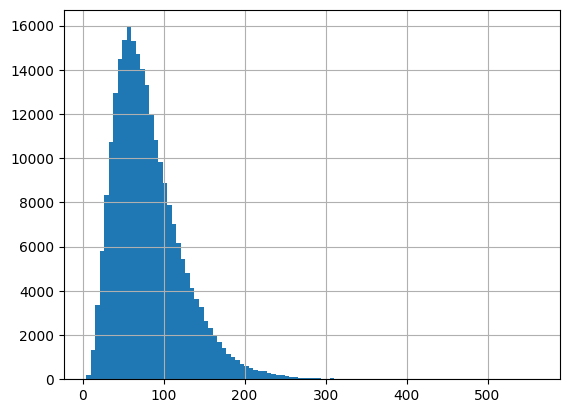

In [3]:
adata.obs['cell_area'].hist(bins=100)

<Axes: >

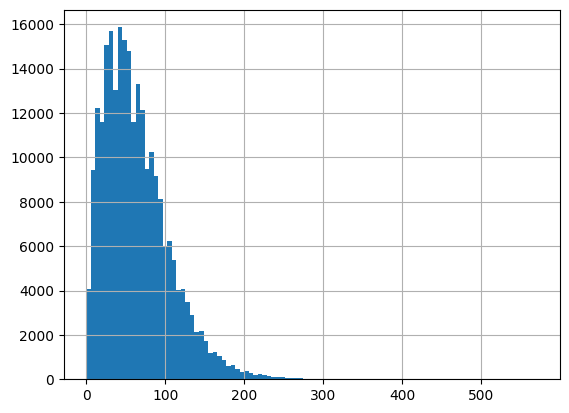

In [4]:
adata.to_df().sum(axis=1).hist(bins=100)


<Axes: >

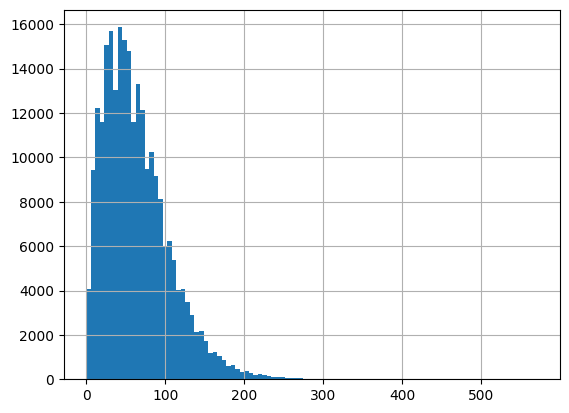

In [5]:
adata.to_df().sum(axis=1).hist(bins=100)

In [6]:
import numpy as np

cell_area = adata.obs['cell_area'].values

if isinstance(adata.X, np.ndarray):
    adata.X = adata.X / cell_area[:, np.newaxis]
else:
    adata.X.data = adata.X.data / np.repeat(cell_area, np.diff(adata.X.indptr))

print("Normalized by cell area completed.")


Normalized by cell area completed.


<Axes: >

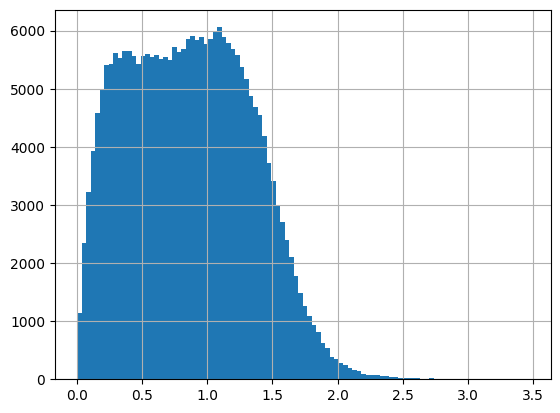

In [7]:
adata.to_df().sum(axis=1).hist(bins=100)


In [8]:
# 各細胞ごとの総発現量を計算（面積で割った後）
total_counts_after_norm = np.array(adata.X.sum(axis=1)).flatten()

# 閾値（0.6）でフィルタリング
adata = adata[total_counts_after_norm >= 0.2, :]

In [9]:
#adata.to_df().sum(axis=1).hist(bins=100)

In [10]:
import scanpy as sc
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
#sc.pp.scale(adata, max_value=10)

In [11]:
joblib.dump(adata, intermediate_joblib_path)

['/Users/masaki/ovarian_can/data/interim/intermediate_after_scale.joblib']